In [1]:
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import torch

DEVICE = torch.device('cuda')

INPUT_WIDTH = 224
INPUT_HEIGHT = 224

paths_labeled = list(Path('train/simpsons_dataset').glob('**/*.jpg'))
paths_test = list(Path('testset/testset').glob('**/*.jpg'))

label_encoder = LabelEncoder().fit([f.parent.name for f in paths_labeled])

from torchvision import transforms

pre_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

from sklearn.model_selection import train_test_split
paths_train, paths_val = train_test_split(paths_labeled)

from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision

class SimpsonsDataset(Dataset):
    def __init__(self, filepaths, has_labels=True):
        self.filepaths = sorted(filepaths)
        self.has_labels = has_labels
        self.labels = [label_encoder.transform([f.parent.name])[0] for f in self.filepaths] if has_labels else None

    def __getitem__(self, index):
        img = Image.open(self.filepaths[index]).resize((INPUT_WIDTH, INPUT_HEIGHT))
        X = pre_transforms(np.array(img, dtype=np.float32) / 255)
        return (X, self.labels[index]) if self.has_labels else X

    def __len__(self):
        return len(self.filepaths)

dataset_train = SimpsonsDataset(paths_train)
dataset_val = SimpsonsDataset(paths_val)
dataset_test = SimpsonsDataset(paths_test, has_labels=False)

import matplotlib.pyplot as plt

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

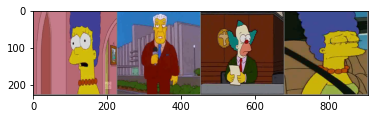

['marge_simpson' 'kent_brockman' 'krusty_the_clown' 'marge_simpson']


In [7]:
images, labels = iter(DataLoader(dataset_train, batch_size=4, shuffle=True)).next()
imshow(torchvision.utils.make_grid(images))
print(label_encoder.inverse_transform(labels))

In [34]:
from tqdm import tqdm

def fit_one_epoch(model, data_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.train()
    for x_batch, y_batch in tqdm(data_loader, 'train epoch batches'):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * x_batch.size(0)
        running_corrects += torch.sum(preds == y_batch).item()
        processed_size += x_batch.size(0)
    
    return running_loss / processed_size, running_corrects / processed_size

In [35]:
from tqdm import tqdm

def validate_one_epoch(model, data_loader, criterion):
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in tqdm(data_loader, 'validate epoch batches'):
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            preds = torch.argmax(outputs, 1)
            running_loss += loss.item() * x_batch.size(0)
            running_corrects += torch.sum(preds == y_batch).item()
            processed_size += x_batch.size(0)
    
    return running_loss / processed_size, running_corrects / processed_size

In [49]:
from tqdm import tqdm

def run_predict(model, data_loader):
    logits = []
    model.eval()
    with torch.no_grad():
        for x_batch in tqdm(data_loader, 'test epoch batches'):
            x_batch = x_batch.to(DEVICE)
            outputs = model(x_batch.view(x_batch.size(0), -1))
            preds = torch.argmax(outputs, 1)
            logits.append(preds)
    
    return torch.cat(logits)

In [48]:
run_predict(model, DataLoader(dataset_test, batch_size=64))

test epoch batches: 100%|██████████| 16/16 [00:01<00:00,  8.11it/s]


tensor([25, 37, 37, 37, 37, 37, 37, 37, 32, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        27, 37, 25, 37, 37, 37, 37, 37,  7, 37, 37, 37, 37, 37, 37, 37, 27, 37,
        27, 37, 37, 37, 37, 37, 37, 15, 37, 37, 37, 37,  4, 37, 37, 37, 37, 37,
        37, 28, 35, 37, 37, 37, 37, 37, 37, 25, 37, 37, 32, 37, 37, 37, 37, 37,
        37, 37, 37, 25, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
        33, 25, 37, 37, 37, 37, 37, 37, 37, 27, 28, 37, 37, 25, 37, 37, 37, 37,
        37, 37, 37, 37, 32, 37, 21, 37, 37, 20, 37, 37, 37, 37, 37, 37, 37, 33,
        37, 20, 37, 37, 37, 37, 37, 37, 37, 37, 32, 37, 37, 37, 37, 32, 37, 37,
        21, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 32, 37,
        27, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 22, 28, 37, 25, 16,
        37, 32, 37, 37, 37, 37, 21, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 32,
        37, 37, 37, 37, 37, 27, 37, 37, 37, 37, 37, 25, 37, 32, 37, 32, 37, 37,
        37, 37, 25, 37, 20, 37, 37, 37, 